# Notebook 2 - SQL avec vraies bases de données
## Analyse e-commerce avec PostgreSQL en ligne




### 🎯 Objectifs pédagogiques
- Connecter Python à une vraie base de données PostgreSQL
- Écrire des requêtes SQL complexes sur des données réelles
- Implémenter des analyses RFM avec SQL
- Intégrer SQL et pandas pour des analyses avancées
- Gérer les connexions et la sécurité

### 🛍️ Contexte du projet
Vous analysez les données d'un vrai dataset e-commerce (Brazilian E-Commerce Public Dataset) hébergé sur une base PostgreSQL.

Objectif : créer une segmentation clientèle pour optimiser les campagnes marketing.


## Partie 1 : Connexion à la base de données réelle

### 🔧 Installation et configuration


# Installation des dépendances


```
pip install psycopg2-binary sqlalchemy pandas python-dotenv
```




In [3]:
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sqlalchemy import text
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv
load_dotenv() 
#from dotenv import load_dotenv

True

### 🌐 Base de données PostgreSQL gratuite (ElephantSQL)

**Option 1 : ElephantSQL (20MB gratuit)**
1. Créez un compte sur [elephantsql.com](https://www.elephantsql.com/)
2. Créez une instance "Tiny Turtle" (gratuite)
3. Récupérez vos credentials

**Option 2 : Supabase (500MB gratuit)**
1. Créez un compte sur [supabase.com](https://supabase.com/)
2. Créez un nouveau projet
3. Récupérez l'URL de connexion PostgreSQL

In [4]:

# Configuration
DATABASE_CONFIG = {
    'host':     os.getenv('SUPABASE_HOST'),
    'database': os.getenv('SUPABASE_DATABASE'),
    'user':     os.getenv('SUPABASE_USER'),
    'password': os.getenv('SUPABASE_PASSWORD'),
    'port':     os.getenv('SUPABASE_PORT')
}

# URL SQLAlchemy
DATABASE_URL = (
    f"postgresql://{DATABASE_CONFIG['user']}:{DATABASE_CONFIG['password']}@"
    f"{DATABASE_CONFIG['host']}:{DATABASE_CONFIG['port']}/{DATABASE_CONFIG['database']}"
)

# Création de l'engine
engine = create_engine(DATABASE_URL)

# Test de connexion
def test_connection():
    try:
        version = pd.read_sql("SELECT version();", engine).iloc[0, 0]
        print("\nConnexion réussie !")
        print("Version PostgreSQL :", version.split()[1])
    except Exception as e:
        print(f"\nErreur de connexion : {e}")

# Lancer le test
test_connection()



Connexion réussie !
Version PostgreSQL : 17.4


In [5]:


# Chemin vers le dossier contenant les CSV
DATA_DIR = "."  # à adapter si tes fichiers sont dans un sous-dossier

csv_files = {
    "customers": "olist_customers_dataset.csv",
    "orders": "olist_orders_dataset.csv",
    "order_items": "olist_order_items_dataset.csv",
    "products": "olist_products_dataset.csv",
    "sellers": "olist_sellers_dataset.csv"
}

# Dictionnaire qui contiendra les 5 DataFrames
dfs = {}

for name, file in csv_files.items():
    path = os.path.join(DATA_DIR, file)
    dfs[name] = pd.read_csv(path)
    print(f"{name:<12} : {dfs[name].shape[0]:>6} lignes × {dfs[name].shape[1]:>2} colonnes")



customers    :  99441 lignes ×  5 colonnes
orders       :  99441 lignes ×  8 colonnes
order_items  : 112650 lignes ×  7 colonnes
products     :  32951 lignes ×  9 colonnes
sellers      :   3095 lignes ×  4 colonnes


In [6]:
## Exploration 2
# Explorer les valeurs manquantes pour chaque DataFrame
for name, df in dfs.items():
    print(f"\nDonnées manquantes dans : {name}")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print("Aucune valeur manquante")
    else:
        for col, count in missing.items():
            print(f"{col:<30} : {count} valeur(s) manquante(s)")


Données manquantes dans : customers
Aucune valeur manquante

Données manquantes dans : orders
order_approved_at              : 160 valeur(s) manquante(s)
order_delivered_carrier_date   : 1783 valeur(s) manquante(s)
order_delivered_customer_date  : 2965 valeur(s) manquante(s)

Données manquantes dans : order_items
Aucune valeur manquante

Données manquantes dans : products
product_category_name          : 610 valeur(s) manquante(s)
product_name_lenght            : 610 valeur(s) manquante(s)
product_description_lenght     : 610 valeur(s) manquante(s)
product_photos_qty             : 610 valeur(s) manquante(s)
product_weight_g               : 2 valeur(s) manquante(s)
product_length_cm              : 2 valeur(s) manquante(s)
product_height_cm              : 2 valeur(s) manquante(s)
product_width_cm               : 2 valeur(s) manquante(s)

Données manquantes dans : sellers
Aucune valeur manquante


In [7]:
# Afficher le nom et le type de chaque colonne dans chaque CSV
for name, df in dfs.items():
    print(f"\nStructure du fichier : {name}")
    for col, dtype in df.dtypes.items():
        print(f"{col:<35} : {dtype}")



Structure du fichier : customers
customer_id                         : object
customer_unique_id                  : object
customer_zip_code_prefix            : int64
customer_city                       : object
customer_state                      : object

Structure du fichier : orders
order_id                            : object
customer_id                         : object
order_status                        : object
order_purchase_timestamp            : object
order_approved_at                   : object
order_delivered_carrier_date        : object
order_delivered_customer_date       : object
order_estimated_delivery_date       : object

Structure du fichier : order_items
order_id                            : object
order_item_id                       : int64
product_id                          : object
seller_id                           : object
shipping_limit_date                 : object
price                               : float64
freight_value                       : float64

In [8]:
######### Suppression des colonnes inutiles ##########

# Customers
dfs["customers"].drop(columns="customer_unique_id", inplace=True)
dfs["customers"].drop(columns="customer_zip_code_prefix", inplace=True)

# Orders
dfs["orders"].drop(columns="order_approved_at", inplace=True)
dfs["orders"].drop(columns="order_delivered_carrier_date", inplace=True)
dfs["orders"].drop(columns="order_estimated_delivery_date", inplace=True)

# Order_items
dfs["order_items"].drop(columns="shipping_limit_date", inplace=True)
dfs["order_items"].drop(columns="order_item_id", inplace=True)

# Products
dfs["products"].drop(columns="product_name_lenght", inplace=True)
dfs["products"].drop(columns="product_description_lenght", inplace=True)
dfs["products"].drop(columns="product_photos_qty", inplace=True)
dfs["products"].drop(columns="product_length_cm", inplace=True)
dfs["products"].drop(columns="product_height_cm", inplace=True)
dfs["products"].drop(columns="product_width_cm", inplace=True)

# Sellers
dfs["sellers"].drop(columns="seller_zip_code_prefix", inplace=True)




######### Rename des colonnes ##########

# Orders 
dfs["orders"].rename(columns={"order_purchase_timestamp": "order_date"}, inplace=True)
dfs["orders"].rename(columns={"order_delivered_customer_date": "order_delivered_date"}, inplace=True)

# Products
dfs["products"].rename(columns={"product_category_name": "product_category"}, inplace=True)



In [9]:
## Exploration 2
# Explorer les valeurs manquantes pour chaque DataFrame
for name, df in dfs.items():
    print(f"\nDonnées manquantes dans : {name}")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print("Aucune valeur manquante")
    else:
        for col, count in missing.items():
            print(f"{col:<30} : {count} valeur(s) manquante(s)")


Données manquantes dans : customers
Aucune valeur manquante

Données manquantes dans : orders
order_delivered_date           : 2965 valeur(s) manquante(s)

Données manquantes dans : order_items
Aucune valeur manquante

Données manquantes dans : products
product_category               : 610 valeur(s) manquante(s)
product_weight_g               : 2 valeur(s) manquante(s)

Données manquantes dans : sellers
Aucune valeur manquante


In [10]:
# Supprimer les lignes où la colonne 'product_category' est vide
dfs["products"].dropna(subset=["product_category"], inplace=True)


# Supprimer les lignes où la colonne 'product_weight_g' est vide
dfs["products"].dropna(subset=["product_weight_g"], inplace=True)

In [11]:
## Exploration 3
# Explorer les valeurs manquantes pour chaque DataFrame
for name, df in dfs.items():
    print(f"\nDonnées manquantes dans : {name}")
    missing = df.isnull().sum()
    missing = missing[missing > 0]
    if missing.empty:
        print("Aucune valeur manquante")
    else:
        for col, count in missing.items():
            print(f"{col:<30} : {count} valeur(s) manquante(s)")



### On conserve les données manquantes dans order_delivered_date car il est tout 
### à fait possible de ne pas encore avoir réceptionné son colis


Données manquantes dans : customers
Aucune valeur manquante

Données manquantes dans : orders
order_delivered_date           : 2965 valeur(s) manquante(s)

Données manquantes dans : order_items


Aucune valeur manquante

Données manquantes dans : products
Aucune valeur manquante

Données manquantes dans : sellers
Aucune valeur manquante


In [12]:
# Conversion des colonnes en datetime (timestamp)
dfs["orders"]["order_date"] = pd.to_datetime(dfs["orders"]["order_date"])
dfs["orders"]["order_delivered_date"] = pd.to_datetime(dfs["orders"]["order_delivered_date"])

In [13]:
# Afficher le nom et le type de chaque colonne dans chaque CSV
for name, df in dfs.items():
    print(f"\nStructure du fichier : {name}")
    for col, dtype in df.dtypes.items():
        print(f"{col:<35} : {dtype}")


Structure du fichier : customers
customer_id                         : object
customer_city                       : object
customer_state                      : object

Structure du fichier : orders
order_id                            : object
customer_id                         : object
order_status                        : object
order_date                          : datetime64[ns]
order_delivered_date                : datetime64[ns]

Structure du fichier : order_items
order_id                            : object
product_id                          : object
seller_id                           : object
price                               : float64
freight_value                       : float64

Structure du fichier : products
product_id                          : object
product_category                    : object
product_weight_g                    : float64

Structure du fichier : sellers
seller_id                           : object
seller_city                         : object
selle

In [14]:
# Récupération depuis le dictionnaire
df_order_items = dfs["order_items"]
df_products = dfs["products"]

# Détection des produits orphelins (absents de la table products)
orphans = df_order_items[~df_order_items["product_id"].isin(df_products["product_id"])]

print(f"Produits absents de 'products' : {len(orphans)}")
print("Aperçu de quelques product_id manquants :", orphans["product_id"].unique()[:10])


Produits absents de 'products' : 1604
Aperçu de quelques product_id manquants : ['ff6caf9340512b8bf6d2a2a6df032cfa' 'a9c404971d1a5b1cbc2e4070e02731fd'
 '5a848e4ab52fd5445cdc07aab1c40e48' '41eee23c25f7a574dfaf8d5c151dbb12'
 'e10758160da97891c2fdcbc35f0f031d' '76d1a1a9d21ab677a61c3ae34b1b352f'
 'fbb1cfc2810efabf3235eccf4530f4ae' '9f69acd4da62618a3f6365b732d00ccd'
 'ea11e700a343582ad56e4c70e966cb36' '8c0bd0d6526379599b74a3a006d4c124']


In [15]:
df_order_items = dfs["order_items"]
df_products = dfs["products"]

# Ne garder que les order_items avec un product_id présent dans products
df_order_items_filtered = df_order_items[df_order_items["product_id"].isin(df_products["product_id"])]

# Mise à jour dans le dictionnaire
dfs["order_items"] = df_order_items_filtered


In [16]:
print(df_order_items_filtered["product_id"].dtype)
print(df_products["product_id"].dtype)

object
object


In [17]:
# Récupération depuis le dictionnaire
df_order_items = dfs["order_items"]
df_products = dfs["products"]

# Détection des produits orphelins (absents de la table products)
orphans = df_order_items[~df_order_items["product_id"].isin(df_products["product_id"])]

print(f"Produits absents de 'products' : {len(orphans)}")
print("Aperçu de quelques product_id manquants :", orphans["product_id"].unique()[:10])


Produits absents de 'products' : 0
Aperçu de quelques product_id manquants : []


In [18]:
# Etudier le poids des colis
stats = df_products["product_weight_g"].describe()
print(stats)


# Etudier les prix des produits
stats = df_order_items["price"].describe()
print(stats)


count    32340.000000
mean      2276.956586
std       4279.291845
min          0.000000
25%        300.000000
50%        700.000000
75%       1900.000000
max      40425.000000
Name: product_weight_g, dtype: float64
count    111046.000000
mean        120.762337
std         183.339790
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64



## Partie 2 : Import du dataset e-commerce

### 📊 Dataset Brazilian E-Commerce
Nous utilisons le célèbre dataset Olist (100k commandes réelles).

**Tables à créer :**
1. **customers** : customer_id, customer_city, customer_state
2. **orders** : order_id, customer_id, order_status, order_date, order_delivered_date
3. **order_items** : order_id, product_id, seller_id, price, freight_value
4. **products** : product_id, product_category, product_weight_g
5. **sellers** : seller_id, seller_city, seller_state

In [19]:
# ### 🗃️ Création des tables SQL


# def create_tables():
#     create_customers = """
#     CREATE TABLE IF NOT EXISTS customers (
#         customer_id VARCHAR(50) PRIMARY KEY,
#         customer_city VARCHAR(100),
#         customer_state VARCHAR(2),
#         created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
#     );
#     """

#     create_orders = """
#     CREATE TABLE IF NOT EXISTS orders (
#         order_id VARCHAR(50) PRIMARY KEY,
#         customer_id VARCHAR(50) REFERENCES customers(customer_id),
#         order_status VARCHAR(20),
#         order_date TIMESTAMP,
#         order_delivered_date TIMESTAMP,
#         created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
#     );
#     CREATE INDEX IF NOT EXISTS idx_orders_customer_id ON orders(customer_id);
#     """

#     create_products = """
#     CREATE TABLE IF NOT EXISTS products (
#         product_id VARCHAR(50) PRIMARY KEY,
#         product_category VARCHAR(100),
#         product_weight_g INTEGER CHECK (product_weight_g >= 0),
#         created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
#     );
#     """

#     create_sellers = """
#     CREATE TABLE IF NOT EXISTS sellers (
#         seller_id VARCHAR(50) PRIMARY KEY,
#         seller_city VARCHAR(100),
#         seller_state VARCHAR(2),
#         created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
#     );
#     """

#     create_order_items = """
#     CREATE TABLE IF NOT EXISTS order_items (
#         order_item_id SERIAL PRIMARY KEY,
#         order_id VARCHAR(50) REFERENCES orders(order_id),
#         product_id VARCHAR(50) REFERENCES products(product_id),
#         seller_id VARCHAR(50) REFERENCES sellers(seller_id),
#         price NUMERIC(10, 2) CHECK (price >= 0),
#         freight_value NUMERIC(10, 2) CHECK (freight_value >= 0),
#         created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
#     );
#     CREATE INDEX IF NOT EXISTS idx_items_order_id ON order_items(order_id);
#     CREATE INDEX IF NOT EXISTS idx_items_product_id ON order_items(product_id);
#     CREATE INDEX IF NOT EXISTS idx_items_seller_id ON order_items(seller_id);
#     """

#     with engine.connect() as conn:
#         conn.execute(text(create_customers))
#         conn.execute(text(create_products))
#         conn.execute(text(create_sellers))
#         conn.execute(text(create_orders))
#         conn.execute(text(create_order_items))
#         conn.commit()


# create_tables()




In [20]:

# # Assurer que les IDs sont tous en str et bien nettoyés
# df_products["product_id"] = df_products["product_id"].astype(str).str.strip()
# df_order_items["product_id"] = df_order_items["product_id"].astype(str).str.strip()

# # Filtrage des order_items sur ceux dont les product_id existent bien dans products
# df_order_items_filtered = df_order_items[df_order_items["product_id"].isin(df_products["product_id"])]

# # Vérif : y a-t-il encore des orphelins ?
# orphans = df_order_items[~df_order_items["product_id"].isin(df_products["product_id"])]
# if not orphans.empty:
#     print("Produits orphelins détectés dans order_items :")
#     print(orphans["product_id"].unique())
# else:
#     print("Aucun produit orphelin détecté.")

# # Mise à jour du dictionnaire
# dfs["order_items"] = df_order_items_filtered
# dfs["products"] = df_products  # Si jamais modifié



In [21]:
# Envoi de la donnée vers SUPABASE
# ordered_table_names = ["products", "customers", "orders", "sellers", "order_items"]

# for table_name in ordered_table_names:
#     df = dfs[table_name]
#     try:
#         print(f"\nInsertion dans la table : {table_name}")
#         df.to_sql(
#             name=table_name,
#             con=engine,
#             if_exists="append",
#             index=False,
#             method="multi"
#         )
#         print("Insertion réussie")
#     except SQLAlchemyError as e:
#         print(f"Erreur d'insertion dans '{table_name}' : {e}")



## Partie 3 : Requêtes SQL avancées


### 🔍 Analyses SQL à implémenter

#### 1. Analyse RFM (Récence, Fréquence, Montant)
```sql
-- Votre défi : Calculer les métriques RFM pour chaque client
WITH customer_metrics AS (
    SELECT
        c.customer_id,
        c.customer_state,
        -- Récence : jours depuis dernier achat
        DATE_PART('day', CURRENT_DATE - MAX(o.order_delivered_date)) AS recency,
        -- Fréquence : nombre de commandes
        COUNT(DISTINCT o.order_id) AS frequency,
        -- Montant : total dépensé
        SUM(oi.price) AS monetary
        -- Complétez cette requête CTE
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN order_items oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_id, c.customer_state
),

-- Créez les segments RFM (Champions, Loyaux, À risque, etc.)
scored_customers AS (
    SELECT
        customer_id,
        customer_state,
        recency,
        frequency,
        monetary,
        
        NTILE(5) OVER (ORDER BY recency ASC) AS recency_score,      -- plus petit = meilleur
        NTILE(5) OVER (ORDER BY frequency DESC) AS frequency_score, -- plus grand = meilleur
        NTILE(5) OVER (ORDER BY monetary DESC) AS monetary_score
    FROM customer_metrics
)

-- Segmentation selon les scores
SELECT
    customer_id,
    customer_state,
    recency,
    frequency,
    monetary,
    recency_score,
    frequency_score,
    monetary_score,
    CASE
        WHEN recency_score = 5 AND frequency_score = 5 THEN 'Champions'
        WHEN recency_score >= 4 AND frequency_score >= 4 THEN 'Loyal Customers'
        WHEN recency_score <= 2 AND frequency_score >= 4 THEN 'À relancer'
        WHEN recency_score >= 4 AND frequency_score <= 2 THEN 'Clients récents'
        WHEN monetary_score >= 4 THEN 'Clients rentables'
        ELSE 'Others'
    END AS customer_segment
FROM scored_customers;

```

In [22]:
#### 2. Analyse géographique des ventes

  customer_state  total_sales
0             SP   5004752.07
1             RJ   1736924.95
2             MG   1534496.09
3             RS    719067.86
4             PR    657744.28
5             SC    500030.47
6             BA    487660.19
7             DF    293919.59
8             GO    274306.59
9             ES    267029.18


/tmp/ipykernel_749/2492605301.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="customer_state", y="total_sales", palette="viridis")


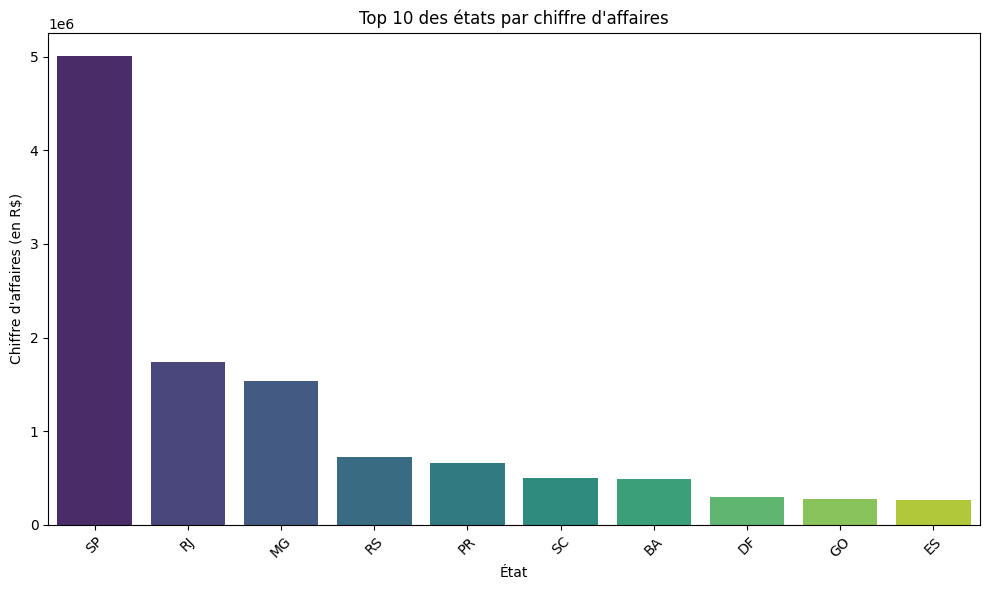

In [23]:

#     1. Top 10 des états par CA
query = """
SELECT
    c.customer_state,
    SUM(oi.price) AS total_sales
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'delivered'
GROUP BY c.customer_state
ORDER BY total_sales DESC
LIMIT 10;
"""

# Récupération des données
df = pd.read_sql(text(query), engine)

# Affichage DataFrame
print(df)

# Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x="customer_state", y="total_sales", palette="viridis")
plt.title("Top 10 des états par chiffre d'affaires")
plt.xlabel("État")
plt.ylabel("Chiffre d'affaires (en R$)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

  region      month  total_revenue  prev_month_revenue  mom_growth_pct
0     AC 2017-02-01         723.14                 NaN             NaN
1     AC 2017-03-01        1127.58              723.14           55.93
2     AC 2017-05-01        3321.67             1127.58          194.58
3     AC 2017-06-01         441.59             3321.67          -86.71
4     AC 2017-07-01         851.77              441.59           92.89


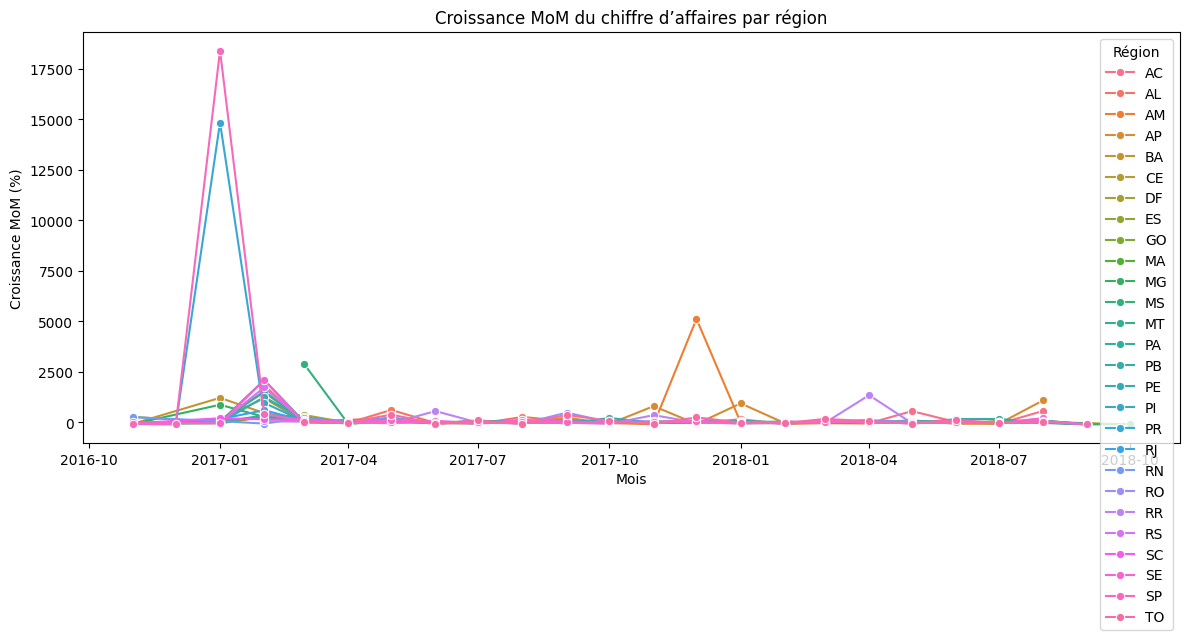

In [24]:
# # #     2. Croissance MoM par région
query = """
WITH monthly_sales AS (
    SELECT
        date_trunc('month', o.order_delivered_date)      AS month,
        c.customer_state                                 AS region,
        SUM(oi.price + COALESCE(oi.freight_value, 0))    AS total_revenue
    FROM orders        o
    JOIN customers     c ON c.customer_id = o.customer_id
    JOIN order_items   oi ON oi.order_id = o.order_id
    WHERE o.order_status = 'delivered'
      AND o.order_delivered_date IS NOT NULL
    GROUP BY 1, 2
),
mom_growth AS (
    SELECT
        region,
        month,
        total_revenue,
        LAG(total_revenue) OVER (PARTITION BY region ORDER BY month) AS prev_month_revenue,
        ROUND(
            (total_revenue - LAG(total_revenue) OVER (PARTITION BY region ORDER BY month))
            / NULLIF(LAG(total_revenue) OVER (PARTITION BY region ORDER BY month), 0) * 100,
            2
        ) AS mom_growth_pct
    FROM monthly_sales
)
SELECT *
FROM mom_growth
ORDER BY region, month;
"""

# Exécution de la requête
df = pd.read_sql(text(query), engine)

# Affichage rapide
print(df.head())      # <-- pour vérifier qu’il y a bien des données

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x='month', y='mom_growth_pct', hue='region', marker='o')
plt.title('Croissance MoM du chiffre d’affaires par région')
plt.ylabel('Croissance MoM (%)')
plt.xlabel('Mois')
plt.legend(title='Région')
plt.tight_layout()
plt.show()

  customer_city  delivered_orders  total_orders  conversion_rate_pct
0       corinto              11.0            11                100.0
1        osorio              35.0            35                100.0
2       cacador              40.0            40                100.0
3       tabapua              12.0            12                100.0
4      pitangui              22.0            22                100.0


/tmp/ipykernel_749/3675517473.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df.head(20), x='conversion_rate_pct', y='customer_city', palette='viridis')


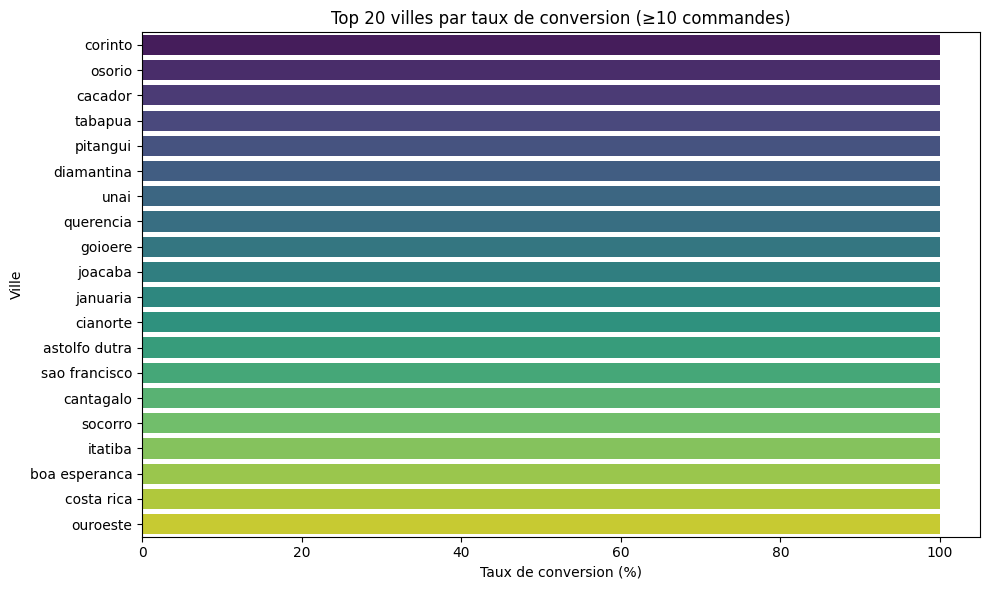

In [25]:
# # #     3. Taux de conversion par ville
query = """
WITH orders_by_city AS (
    SELECT
        c.customer_city,
        COUNT(*) FILTER (WHERE o.order_status = 'delivered')::numeric AS delivered_orders,
        COUNT(*) AS total_orders
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    GROUP BY c.customer_city
),
conversion AS (
    SELECT
        customer_city,
        delivered_orders,
        total_orders,
        ROUND(delivered_orders / NULLIF(total_orders, 0) * 100, 2) AS conversion_rate_pct
    FROM orders_by_city
)
SELECT *
FROM conversion
WHERE total_orders >= 10   -- optionnel, pour filtrer les villes avec trop peu de commandes
ORDER BY conversion_rate_pct DESC;
"""
df = pd.read_sql(text(query), engine)
print(df.head())

plt.figure(figsize=(10,6))
sns.barplot(data=df.head(20), x='conversion_rate_pct', y='customer_city', palette='viridis')
plt.title("Top 20 villes par taux de conversion (≥10 commandes)")
plt.xlabel("Taux de conversion (%)")
plt.ylabel("Ville")
plt.tight_layout()
plt.show()

In [26]:
# #     4. Distance moyenne vendeur-acheteur  ON VERRA PLUS TARD

In [27]:
#     -- Utilisez des JOINs et GROUP BY
#     -- Calculez le CA, nombre de commandes, panier moyen
query_top_states = """
WITH stats AS (
    SELECT
        c.customer_state,
        SUM(oi.price + COALESCE(oi.freight_value, 0))      AS total_revenue,
        COUNT(DISTINCT o.order_id)                         AS nb_orders,
        ROUND(
            SUM(oi.price + COALESCE(oi.freight_value, 0)) /
            NULLIF(COUNT(DISTINCT o.order_id), 0),
            2
        )                                                  AS avg_basket_value
    FROM orders        o
    JOIN customers     c  ON c.customer_id = o.customer_id
    JOIN order_items   oi ON oi.order_id   = o.order_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_state
)
SELECT *
FROM stats
ORDER BY total_revenue DESC;
"""

df = pd.read_sql(query_top_states, engine)
print(df)          # <-- ajout du print

   customer_state  total_revenue  nb_orders  avg_basket_value
0              SP     5698549.55      39963            142.60
1              RJ     2028970.26      12168            166.75
2              MG     1797743.07      11190            160.66
3              RS      849575.14       5269            161.24
4              PR      772074.76       4855            159.03
5              SC      587090.24       3491            168.17
6              BA      583637.01       3215            181.54
7              DF      343004.77       2050            167.32
8              GO      324676.46       1911            169.90
9              ES      315753.20       1978            159.63
10             PE      304173.33       1576            193.00
11             CE      262979.78       1266            207.72
12             PA      202713.37        929            218.21
13             MT      179973.37        874            205.92
14             MA      146095.79        709            206.06
15      

#### 3. Analyse temporelle et saisonnalité
```sql
-- Détectez les patterns saisonniers
SELECT
    EXTRACT(YEAR FROM order_date) as year,
    EXTRACT(MONTH FROM order_date) as month,
    EXTRACT(DOW FROM order_date) as day_of_week,
    COUNT(*) as order_count,
    SUM(price + freight_value) as total_revenue,
    AVG(price + freight_value) as avg_order_value
FROM orders o
JOIN order_items oi ON o.order_id = oi.order_id
WHERE order_status = 'delivered'
GROUP BY ROLLUP(
    EXTRACT(YEAR FROM order_date),
    EXTRACT(MONTH FROM order_date),
    EXTRACT(DOW FROM order_date)
)
ORDER BY year, month, day_of_week;
```

---

In [ ]:
dico1 = {'pomme': 2, 'banane': 3}
dico2 = {'banane': 5, 'orange': 4}

## Partie 4 : Analyse prédictive avec SQL

### 🔮 Modèles simples en SQL

In [ ]:
#### 1. Prédiction de churn
# Les diff indicateurs sauf le changement géographique
# Petite requête qui recup nbr jour depuis dernier achat
# Frequence d'achat
# Prix moyen du panier
def churn_prediction_sql():
    """
    Identifiez les clients à risque de churn

    Indicateurs :
    - Pas d'achat depuis X jours
    - Baisse de fréquence d'achat
    - Diminution du panier moyen
    - Changement de comportement géographique
    """

    churn_query = """
    WITH customer_activity AS (
        -- Calculez les métriques d'activité récente
        -- Comparez avec l'historique du client
        -- Scorez le risque de churn
    )

    SELECT
        customer_id,
        days_since_last_order,
        order_frequency_trend,
        monetary_trend,
        churn_risk_score,
        CASE
            WHEN churn_risk_score > 0.7 THEN 'High Risk'
            WHEN churn_risk_score > 0.4 THEN 'Medium Risk'
            ELSE 'Low Risk'
        END as churn_segment
    FROM customer_activity;
    """

    return pd.read_sql(churn_query, engine)


#### 2. Recommandations produits
```sql
-- Market Basket Analysis simplifié
WITH product_pairs AS (
    SELECT
        oi1.product_id as product_a,
        oi2.product_id as product_b,
        COUNT(*) as co_purchase_count
    FROM order_items oi1
    JOIN order_items oi2 ON oi1.order_id = oi2.order_id
    WHERE oi1.product_id != oi2.product_id
    GROUP BY oi1.product_id, oi2.product_id
    HAVING COUNT(*) >= 10  -- Seuil minimum
)

SELECT
    product_a,
    product_b,
    co_purchase_count,
    co_purchase_count::float / total_a.count as confidence
FROM product_pairs pp
JOIN (
    SELECT product_id, COUNT(*) as count
    FROM order_items
    GROUP BY product_id
) total_a ON pp.product_a = total_a.product_id
ORDER BY confidence DESC;
```

---

## Partie 5 : Intégration avec les APIs météo

### 🌤️ Croisement données météo/ventes
```python
def weather_sales_correlation():
    """
    Correlez vos données météo du Notebook 1 avec les ventes
    
    Hypothèses à tester :
    1. Les ventes de certaines catégories augmentent-elles avec la pluie ?
    2. Y a-t-il un impact de la température sur les achats ?
    3. Les livraisons sont-elles impactées par la météo ?
    """
    
    # Récupérez les données météo historiques pour les villes brésiliennes
    weather_query = """
    SELECT DISTINCT customer_city, customer_state
    FROM customers
    WHERE customer_state IN ('SP', 'RJ', 'MG', 'RS', 'SC')
    ORDER BY customer_city;
    """
    
    cities = pd.read_sql(weather_query, engine)
    
    # Intégrez avec l'API météo
    # Analysez les corrélations
    
    pass
```

### 📊 Dashboard géo-temporel
```python
def create_geotemporal_dashboard():
    """
    Créez un dashboard interactif combinant :
    - Carte des ventes par région
    - Évolution temporelle avec météo
    - Segments clients géolocalisés
    - Prédictions par zone géographique
    """
    pass
```

---
## 🏆 Livrables finaux

### 📈 Rapport d'analyse complet
1. **Segmentation RFM (Recency, Frenquency, Monetary) ** : 5-7 segments avec caractéristiques
2. **Analyse géographique**  : Performances par région + recommandations
3. **Prédictions churn** : Liste des clients à risque + actions
4. **Recommandations produits** : Top 10 des associations
5. **Impact météo** : Corrélations significatives identifiées

### 🚀 Pipeline automatisé
```python
def automated_analysis_pipeline():
    """
    Pipeline qui :
    1. Se connecte à la DB
    2. Exécute toutes les analyses
    3. Met à jour les segments clients
    4. Génère le rapport automatiquement
    5. Envoie des alertes si nécessaire
    """
    pass
```

---

## 🎓 Auto-évaluation

- [ ] **Connexion DB** : PostgreSQL fonctionnelle
- [ ] **Requêtes complexes** : JOINs, CTEs, fonctions analytiques
- [ ] **Gestion des erreurs** : Connexions robustes
- [ ] **Performance** : Requêtes optimisées avec index
- [ ] **Intégration** : SQL + Python + APIs
- [ ] **Insights actionables** : Recommandations business claires

### 🔗 Préparation au Notebook 3
Le prochain notebook portera sur NoSQL (MongoDB) avec des données de réseaux sociaux et d'IoT, en temps réel.

### 💡 Bases de données alternatives
- **PlanetScale** : MySQL serverless gratuit
- **MongoDB Atlas** : 512MB gratuit
- **FaunaDB** : Base multi-modèle gratuite
- **Hasura Cloud** : GraphQL + PostgreSQL